In [54]:
import importlib
import micasense.imageset
import micasense.capture
import micasense.imageset as imageset
import micasense.capture as capture
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import cv2
import os, glob
import json
import tqdm
import pickle #This library will maintain the format as well
from osgeo import gdal,osr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as Image
import exiftool
import datetime
from math import ceil

import algorithms.mutils as mutils
import algorithms.radiometric_calib_utils as rcu
import algorithms.extract_spectral as espect
import algorithms.flight_attributes
import algorithms.validate_algorithm

importlib.reload(algorithms.validate_algorithm)
importlib.reload(algorithms.flight_attributes)

import algorithms.flight_attributes as FlightAttributes
import algorithms.validate_algorithm as ValidateAlgo

# Get panel images, panel reflectance, warp matrices

In [2]:
panelNames = None
useDLS = True

# imagePath = os.path.expanduser(os.path.join('~','Downloads','DualCam-Farm','farm_only'))
# panelNames = glob.glob(os.path.join(imagePath,'IMG_0002_*.tif'))

imagePath =  r"D:\EPMC_flight\pandanResTest\F2\RawImg"#r"D:\EPMC_flight\pandanResTest\F1\RawImg"
panelNames = glob.glob(os.path.join(imagePath,'IMG_0000_*.tif'))

outputPath = os.path.join(imagePath,'..','stacks')
thumbnailPath = os.path.join(outputPath, '..', 'thumbnails')

overwrite = False # Set to False to continue interrupted processing
generateThumbnails = True

# Allow this code to align both radiance and reflectance images; bu excluding
# a definition for panelNames above, radiance images will be used
# For panel images, efforts will be made to automatically extract the panel information
# but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
# will need to be set in the panel_reflectance_by_band variable.
# Note: radiance images will not be used to properly create NDVI/NDRE images below.
if panelNames is not None:
    panelCap = micasense.capture.Capture.from_filelist(panelNames)
    warp_matrices = panelCap.get_warp_matrices()
    cropped_dimensions, _ = micasense.imageutils.find_crop_bounds(panelCap, warp_matrices, warp_mode=cv2.MOTION_HOMOGRAPHY)
    print(cropped_dimensions)
else:
    panelCap = None
    warp_matrices = None
if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.65]*len(panelCap.images) #inexact, but quick
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
else:
    if useDLS:
        img_type='reflectance'
    else:
        img_type = "radiance"

(4.0, 6.0, 1239.0, 919.0)


# Batch import and process all images

In [3]:
# batch import images
imgset = imageset.ImageSet.from_directory(imagePath)

use_multi_process = True # set to False for single-process saving
overwrite_existing = False # skip existing files, set to True to overwrite

if not os.path.exists(outputPath):
    os.makedirs(outputPath)
if generateThumbnails and not os.path.exists(thumbnailPath):
    os.makedirs(thumbnailPath)

# If we didn't provide a panel above, irradiance set to None will cause DLS data to be used
try:
    irradiance = panel_irradiance+[0]
except NameError:
    irradiance = None

start_time = datetime.datetime.now()

# Save all captures in the imageset as aligned stacks
imgset.process_imageset(outputPath,
                     thumbnailPath,
                     warp_matrices,
                     irradiance = irradiance,
                     img_type='reflectance',
                     multiprocess=use_multi_process, 
                     overwrite=overwrite_existing)

end_time = datetime.datetime.now()

print("Saving time: {}".format(end_time-start_time))
print("Alignment+Saving rate: {:.2f} captures per second".format(float(len(imgset.captures))/float((end_time-start_time).total_seconds())))

Loading ImageSet from: D:\EPMC_flight\3rdSur18May\F1\RawImg
Processing 613 Captures ...
Processing complete.
Saving time: 0:17:42.155983
Alignment+Saving rate: 0.58 captures per second


## Import saved band_aligned images

In [3]:
imagePath =  r"D:\EPMC_flight\pandanResTest\F2\RawImg"
if os.path.exists(os.path.join(os.path.dirname(imagePath),'thumbnails')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

fp_list

['D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0000_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0001_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0002_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0003_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0004_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0005_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0006_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0007_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0008_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0009_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0010_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0011_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0012_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0013_1.jpg',
 'D:\\EPMC_flight\\pandanResTest\\F2\\thumbnails\\IMG_0014_1.j

## Import flight attributes df

In [37]:
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None

flight_attributes_df

timestamp  latitude   longitude  altitude  \
0    2022-12-12 03:57:49.580447+00:00  1.318993  103.736566    21.087   
1    2022-12-12 03:58:01.375906+00:00  1.318994  103.736560    20.668   
2    2022-12-12 03:58:06.763455+00:00  1.318993  103.736560    20.738   
3    2022-12-12 03:58:14.126010+00:00  1.318990  103.736558    20.748   
4    2022-12-12 04:05:13.319729+00:00  1.318973  103.736598    46.909   
..                                ...       ...         ...       ...   
195  2022-12-12 04:10:31.699520+00:00  1.318579  103.736206    50.559   
196  2022-12-12 04:10:33.991551+00:00  1.318580  103.736184    50.478   
197  2022-12-12 04:10:35.879041+00:00  1.318540  103.736175    50.352   
198  2022-12-12 04:10:37.496038+00:00  1.318494  103.736172    50.264   
199  2022-12-12 04:10:39.217919+00:00  1.318449  103.736188    50.212   

         image_name            capture_id   dls-yaw  dls-pitch  dls-roll  \
0    IMG_0000_1.tif  D1dqcVbYFpWLrqrhxp65  1.768448  -0.024328  0.037788   
1    IMG_0001_1.tif  LMTJeVzIycDVmOMUumUb  1.788463  -0.038676  0.020124   
2    IMG_0002_1.tif  StCrPCqY7hHXw8Hi0KFT  1.789900  -0.056701  0.007901   
3    IMG_0003_1.tif  1tfFGUbfuImG2Yocxjy6  1.777689  -0.093409 -0.037415   
4    IMG_0004_1.tif  1wg4rPxOLYgcuZEroYSA  1.831188  -0.017768 -0.018996   
..              ...                   ...       ...        ...       ...   
195  IMG_0195_1.tif  IS6TlJ7sRxxww7Eznvbd -0.254191  -0.009937 -0.045614   
196  IMG_0196_1.tif  EHWL7rV2OwMWXDmN2eXA -2.735515  -0.086592 -0.012487   
197  IMG_0197_1.tif  aYePc5Z9M5L2PcfWwxmp -2.771658  -0.086177 -0.047550   
198  IMG_0198_1.tif  8zpetseSkcuZwbd5y4GD  3.002090  -0.056153 -0.092705   
199  IMG_0199_1.tif  c5oM2zTNQo9z8qgYb2Rc  2.788039  -0.063716  0.022738   

      irr-475   irr-560   irr-668   irr-842   irr-717   irr-444   irr-531  \
0    0.526376  0.465279  0.392283  0.241601  0.302945  0.467606  0.483118   
1    0.527561  0.466350  0.393259  0.242179  0.303673  0.468595  0.484220   
2    0.528551  0.467233  0.394027  0.242640  0.304250  0.469456  0.485130   
3    0.528455  0.467123  0.394005  0.242590  0.304218  0.469292  0.485018   
4    0.576662  0.511715  0.430489  0.265818  0.331959  0.513646  0.530690   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.569590  0.504434  0.423628  0.261537  0.327051  0.507747  0.523478   
196  0.570460  0.505700  0.425010  0.262405  0.327994  0.508340  0.524625   
197  0.569283  0.504853  0.424308  0.262028  0.327462  0.507323  0.523689   
198  0.568230  0.504022  0.423668  0.261633  0.326930  0.506361  0.522789   
199  0.566952  0.502978  0.422781  0.261100  0.326208  0.505250  0.521677   

      irr-650   irr-705   irr-740  
0    0.385711  0.346326  0.320788  
1    0.386642  0.347184  0.321587  
2    0.387385  0.347855  0.322215  
3    0.387333  0.347848  0.322225  
4    0.423705  0.379125  0.350854  
..        ...       ...       ...  
195  0.417164  0.373395  0.345588  
196  0.418461  0.374500  0.346558  
197  0.417805  0.373846  0.345911  
198  0.417162  0.373247  0.345351  
199  0.416291  0.372423  0.344577  

[200 rows x 19 columns]

### View flight altitude

52.493


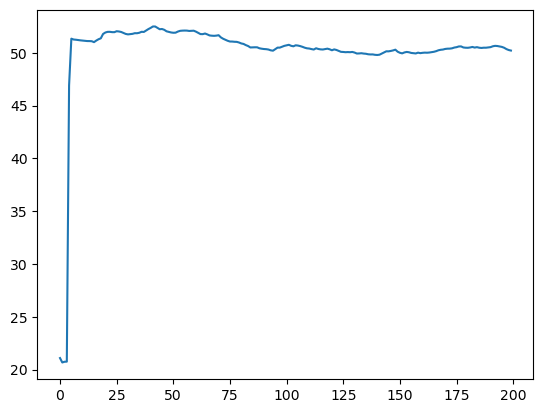

In [5]:
plt.figure()
plt.plot(flight_attributes_df.index.to_list(),flight_attributes_df['altitude'])
# plt.title(f'Max height: {}')
print(np.max(flight_attributes_df['altitude'].values))
plt.show()

# Interpolate Flight

0it [00:00, ?it/s]

200it [00:00, 1527.01it/s]
200it [00:00, 1489.51it/s]


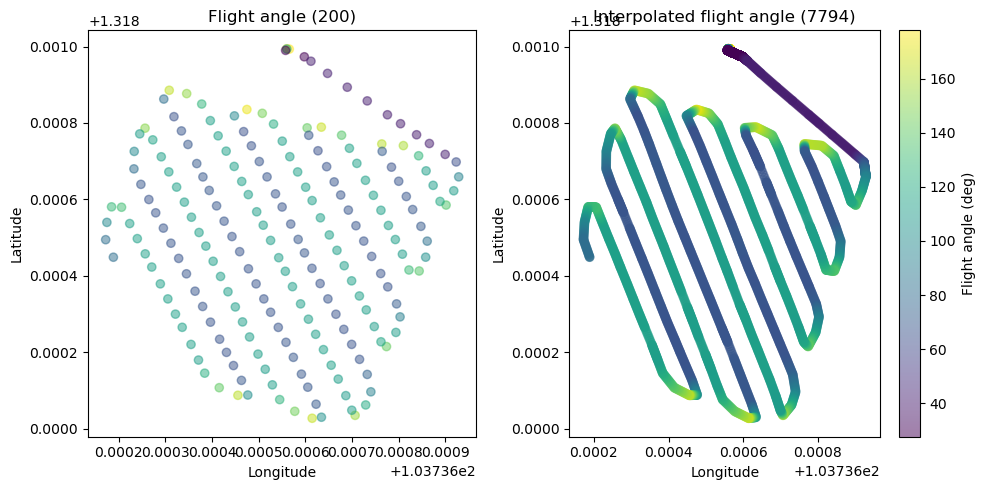

timestamp   timedelta  latitude   longitude  \
0    2022-12-12 03:57:49.580447+00:00    0.000000  1.318993  103.736566   
1    2022-12-12 03:57:49.680447+00:00    0.100000  1.318993  103.736566   
2    2022-12-12 03:57:49.780447+00:00    0.200000  1.318993  103.736566   
3    2022-12-12 03:57:49.880447+00:00    0.300000  1.318993  103.736565   
4    2022-12-12 03:57:49.980447+00:00    0.400000  1.318993  103.736565   
...                               ...         ...       ...         ...   
7789 2022-12-12 04:10:38.896038+00:00  769.315591  1.318457  103.736185   
7790 2022-12-12 04:10:38.996038+00:00  769.415591  1.318455  103.736186   
7791 2022-12-12 04:10:39.096038+00:00  769.515591  1.318452  103.736187   
7792 2022-12-12 04:10:39.196038+00:00  769.615591  1.318449  103.736188   
7793 2022-12-12 04:10:39.217919+00:00  769.615591  1.318449  103.736188   

       altitude  flight_angle     north_vec  east_vec      image_name  \
0     21.087000    177.878904  2.000000e-07 -0.000005  IMG_0000_1.tif   
1     21.083448    177.878904  2.000000e-07 -0.000005  IMG_0000_1.tif   
2     21.079896    177.878904  2.000000e-07 -0.000005  IMG_0000_1.tif   
3     21.076343    177.878904  2.000000e-07 -0.000005  IMG_0000_1.tif   
4     21.072791    177.878904  2.000000e-07 -0.000005  IMG_0000_1.tif   
...         ...           ...           ...       ...             ...   
7789  50.221721     81.334110 -9.120000e-05  0.000014  IMG_0198_1.tif   
7790  50.218701     81.334110 -9.120000e-05  0.000014  IMG_0198_1.tif   
7791  50.215681     81.334110 -9.120000e-05  0.000014  IMG_0198_1.tif   
7792  50.212661     81.334110 -9.120000e-05  0.000014  IMG_0198_1.tif   
7793  50.212000     81.334110 -9.120000e-05  0.000014  IMG_0199_1.tif   

                capture_id  ...   irr-560   irr-668   irr-842   irr-717  \
0     D1dqcVbYFpWLrqrhxp65  ...  0.465279  0.392283  0.241601  0.302945   
1     D1dqcVbYFpWLrqrhxp65  ...  0.465279  0.392283  0.241601  0.302945   
2     D1dqcVbYFpWLrqrhxp65  ...  0.465279  0.392283  0.241601  0.302945   
3     D1dqcVbYFpWLrqrhxp65  ...  0.465279  0.392283  0.241601  0.302945   
4     D1dqcVbYFpWLrqrhxp65  ...  0.465279  0.392283  0.241601  0.302945   
...                    ...  ...       ...       ...       ...       ...   
7789  8zpetseSkcuZwbd5y4GD  ...  0.504022  0.423668  0.261633  0.326930   
7790  8zpetseSkcuZwbd5y4GD  ...  0.504022  0.423668  0.261633  0.326930   
7791  8zpetseSkcuZwbd5y4GD  ...  0.504022  0.423668  0.261633  0.326930   
7792  8zpetseSkcuZwbd5y4GD  ...  0.504022  0.423668  0.261633  0.326930   
7793  c5oM2zTNQo9z8qgYb2Rc  ...  0.502978  0.422781  0.261100  0.326208   

       irr-444   irr-531   irr-650   irr-705   irr-740  index  
0     0.467606  0.483118  0.385711  0.346326  0.320788      0  
1     0.467606  0.483118  0.385711  0.346326  0.320788      0  
2     0.467606  0.483118  0.385711  0.346326  0.320788      0  
3     0.467606  0.483118  0.385711  0.346326  0.320788      0  
4     0.467606  0.483118  0.385711  0.346326  0.320788      0  
...        ...       ...       ...       ...       ...    ...  
7789  0.506361  0.522789  0.417162  0.373247  0.345351    198  
7790  0.506361  0.522789  0.417162  0.373247  0.345351    198  
7791  0.506361  0.522789  0.417162  0.373247  0.345351    198  
7792  0.506361  0.522789  0.417162  0.373247  0.345351    198  
7793  0.505250  0.521677  0.416291  0.372423  0.344577    199  

[7794 rows x 24 columns]

In [6]:
imagePath =  r"D:\EPMC_flight\pandanResTest\F2\RawImg"
# import flight attributes df
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None
IF = FlightAttributes.InterpolateFlight(flight_attributes_df)
df_interpolated = IF.interpolate_flight()
df_interpolated

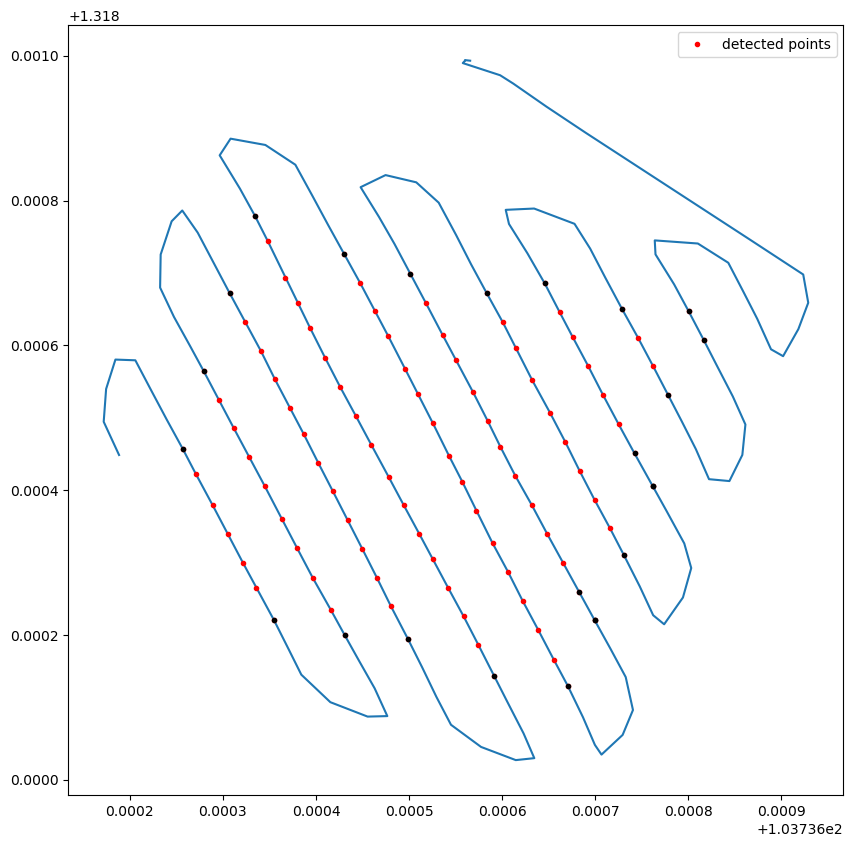

[(26, 27),
 (36, 39),
 (47, 53),
 (54, 54),
 (62, 71),
 (80, 91),
 (92, 92),
 (100, 115),
 (123, 139),
 (148, 160),
 (169, 178),
 (186, 192)]

In [7]:
start_stop_idx = FlightAttributes.get_start_stop_lines(flight_attributes_df, n = 3, thresh=0.99, plot=True)
start_stop_idx

# Georeference images

In [24]:
parent_dir = os.path.join(os.path.dirname(imagePath),'georeferenced_thumbnails')
if not os.path.exists(parent_dir):
    georeferenced_thumbnails_directory = os.path.join(os.path.dirname(imagePath),'georeferenced_thumbnails')
    os.mkdir(georeferenced_thumbnails_directory)

DEM_offset_height = flight_attributes_df['altitude'].min()
column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
for i,rows in flight_attributes_df.iterrows():
    if (i == 0) or (i == len(flight_attributes_df.index)-1):
        pass
    else:
        flight_att = rows[column_idx].tolist()
        flight_att[-2] = flight_att[-2] - DEM_offset_height
        image_name = os.path.splitext(rows['image_name'])[0]
        # estimate flight angle from 2 adjacent coordinates
        flight_att_diff = flight_attributes_df.iloc[[i-1,i+1],column_idx]
        flight_att_diff = flight_att_diff.iloc[:,:2].values
        flight_angle_coord = FlightAttributes.get_flight_angle(flight_att_diff)
        flight_dir = FlightAttributes.get_flight_direction(flight_att_diff)
        flight_angle_coord = flight_angle_coord[0] + 90 if flight_angle_coord[0] > 90 else 90 - flight_angle_coord[0]
        if (flight_dir[0] > 0 and flight_dir[1] > 0) or (flight_dir[0] < 0 and flight_dir[1] < 0):
            flight_angle_coord = (flight_angle_coord + 180)%360
        # open image
        im = np.asarray(Image.open(fp_list[i])) if image_name in fp_list[i] else None
        if im is None:
            print(f"Image not found: {image_name}, {fp_list[i]}")
            pass
        else:
            image_fn = os.path.join(georeferenced_thumbnails_directory,image_name)
            GI = FlightAttributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
            GI.georegister(image_fn)

Image not found: IMG_0599_1, D:\EPMC_flight\3rdSur18May\F1\thumbnails\IMG_0598_1.jpg
Image not found: IMG_0598_1, D:\EPMC_flight\3rdSur18May\F1\thumbnails\IMG_0599_1.jpg


### test

[1.3185367, 103.7362234, 29.936999999999998, -0.2742914350216322]
Flight angle from coords: 112.377
Flight direction: (8.209999999997386e-05, -3.379999999708616e-05)


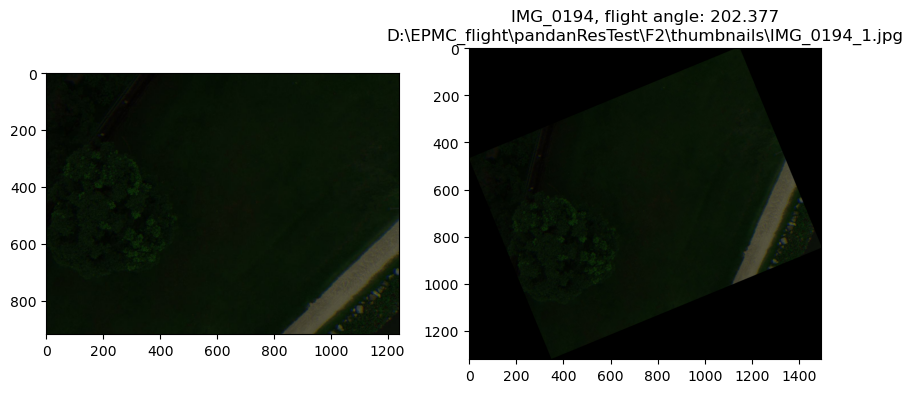

In [8]:
# import image and flight attributes
test_idx = 194#start_stop_idx[0][0]
image_name = 'IMG_{}'.format(str(test_idx).zfill(4))
DEM_offset_height = flight_attributes_df['altitude'].min()
column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
flight_att = flight_attributes_df.iloc[test_idx,column_idx].tolist()
flight_att[-2] = flight_att[-2] - DEM_offset_height
im = np.asarray(Image.open(fp_list[test_idx])) if image_name in fp_list[test_idx] else None
print(flight_att)

# estimate flight angle from coordinates
flight_att_diff = flight_attributes_df.iloc[[test_idx-1,test_idx+1],column_idx]
flight_att_diff = flight_att_diff.iloc[:,:2].values
flight_angle_coord = FlightAttributes.get_flight_angle(flight_att_diff)
flight_dir = FlightAttributes.get_flight_direction(flight_att_diff)
print(f'Flight angle from coords: {flight_angle_coord[0]:.3f}')
print(f'Flight direction: {flight_dir}')
flight_angle_coord = flight_angle_coord[0] + 90 if flight_angle_coord[0] > 90 else 90 - flight_angle_coord[0]
if (flight_dir[0] > 0 and flight_dir[1] > 0) or (flight_dir[0] < 0 and flight_dir[1] < 0):
    flight_angle_coord = (flight_angle_coord + 180)%360
# estimation of flight angle from coordinates is better
# geotransform image
GI = FlightAttributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
rot_im = GI.georegister()
# _ = GI.affine_transformation(plot=True)
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(im)
axes[1].imshow(np.fliplr(rot_im)) #need to fliplr cus QGIS
axes[1].set_title(f'{image_name}, flight angle: {flight_angle_coord:.3f}\n{fp_list[test_idx]}')
plt.show()

In [51]:
x = np.array([1,0])

y1 = np.array([1,1])
y1 = y1/np.linalg.norm(y1)

y2 = np.array([1,-1])
y2 = y2/np.linalg.norm(y2)

y3 = np.array([-1,-1])
y3 = y3/np.linalg.norm(y3)

y4 = np.array([-1,1])
y4 = y4/np.linalg.norm(y4)

vecs_list = [y1,y2,y3,y4]

for vec in vecs_list:
    theta = np.arccos(np.dot(x,vec))/np.pi*180
    print(theta)


x_unit = np.array([0,1])
y_unit = np.array([1,0])

for vec in vecs_list:
    # A = vec - x
    # det = np.dot(A,x_unit)*np.dot(x,y_unit) - np.dot(x,x_unit)*np.dot(A,y_unit)
    # print(det)
    det = np.cross(x,vec)
    print(np.sign(det))

45.00000000000001
45.00000000000001
135.0
135.0
1.0
-1.0
-1.0
1.0


[[  1.3185794 103.7362059]
 [  1.3185398 103.7361745]]
lat,lon,altitude: 1.3185804,103.7361845,50.478
Flight angle from coords: 141.5880705827495
Flight height: 29.810000000000002
Flight direction: (-1.0, -1.0)


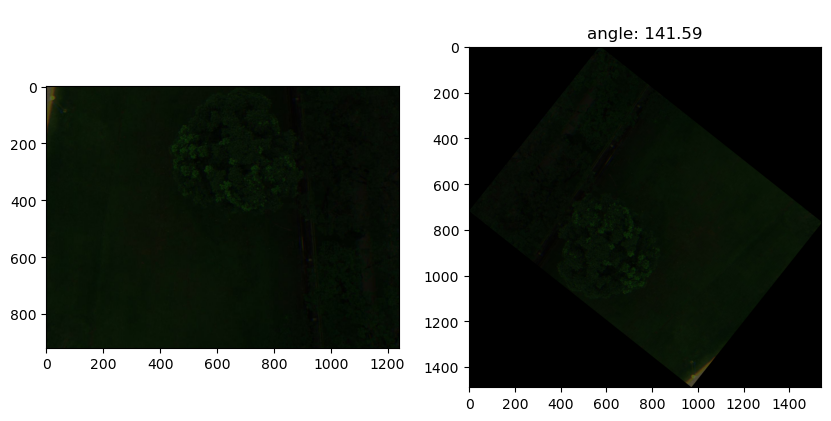

In [60]:
# import image and flight attributes
test_idx = 196#start_stop_idx[0][0]
image_name = 'IMG_{}'.format(str(test_idx).zfill(4))
DEM_offset_height = flight_attributes_df['altitude'].min()
column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude']]
lat,lon,altitude = flight_attributes_df.iloc[test_idx,column_idx].tolist()
# flight_att[-2] = flight_att[-2] - DEM_offset_height
im = np.asarray(Image.open(fp_list[test_idx])) if image_name in fp_list[test_idx] else None

# estimate flight angle from coordinates
flight_att_diff = flight_attributes_df.iloc[[test_idx-1,test_idx+1],column_idx]
flight_att_diff = flight_att_diff.iloc[:,:2].values
print(flight_att_diff)
flight_angle_coord = FlightAttributes.get_flight_angle(flight_att_diff, ref_vec=np.array([1,0]))
print(f'lat,lon,altitude: {lat},{lon},{altitude}')
print(f'Flight angle from coords: {flight_angle_coord}')
print(f'Flight height: {altitude - DEM_offset_height}')

north_vec, east_vec = FlightAttributes.get_flight_direction(flight_att_diff)
print(f'Flight direction: {north_vec, east_vec}')

if east_vec < 0:
    flight_angle = flight_angle_coord # means rotation of image is positive (acw)
else:
    flight_angle = -flight_angle_coord # means rotation of image is negative (cw)
GI = FlightAttributes.GeotransformImage(im,lat,lon,
                                        altitude = altitude - 15,
                                        angle = flight_angle)
_ = GI.georegister('test2')
rot_im = GI.affine_transformation(plot=True)

# Time delay correction

rows shifted: 0
shape of canvas(4582, 5096, 3)


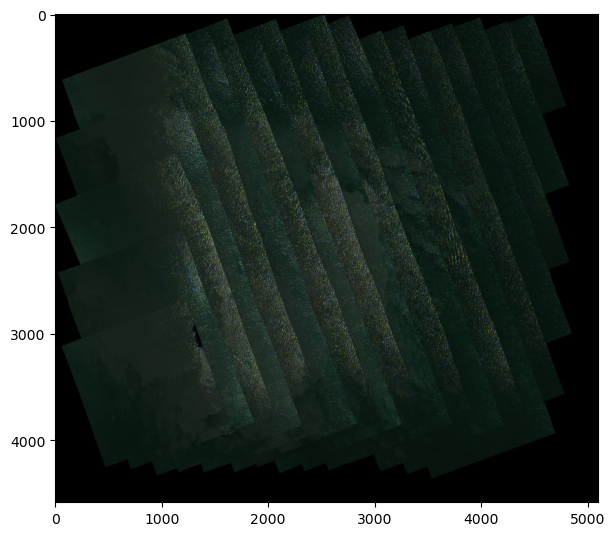

In [23]:
selected_imges = [list(range(start,stop+1)) for start, stop in start_stop_idx]
selected_imges_dict = {i:s for i,s in enumerate(selected_imges)}
df1 = FlightAttributes.time_delta_correction(df_interpolated, timedelta=0)
df_cropped = df1.iloc[[i for l in selected_imges_dict.values() for i in l],:]
PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list)
fig, axes = plt.subplots(figsize=(7,15))
im_display = PG.plot_georeference(reduction_factor=5,plot=False)
axes.imshow(im_display)
plt.show()

rows shifted: -15
shape of canvas(4260, 2345, 3)
rows shifted: -13
shape of canvas(4227, 2344, 3)
rows shifted: -13
shape of canvas(4227, 2344, 3)
rows shifted: -11
shape of canvas(4194, 2341, 3)
rows shifted: -11
shape of canvas(4194, 2341, 3)
rows shifted: -10
shape of canvas(4177, 2341, 3)
rows shifted: -9
shape of canvas(4159, 2342, 3)
rows shifted: -8
shape of canvas(4137, 2342, 3)


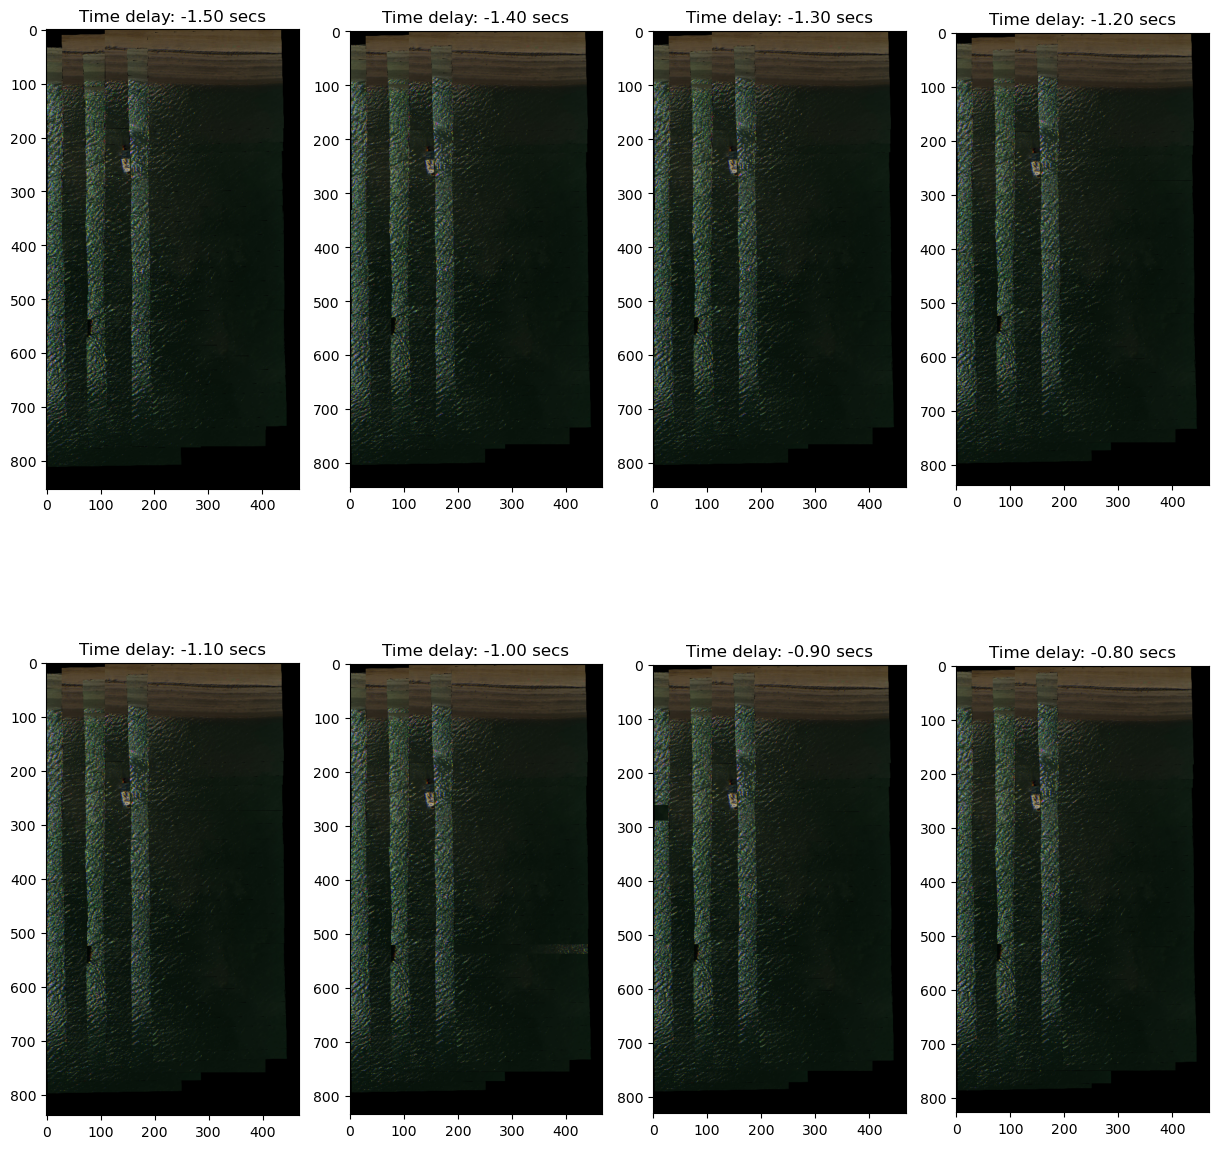

In [28]:
n_fig = 8
fig, axes = plt.subplots(2,4, figsize=(15,15))
selected_idxes = [p for i in range(6) for p in selected_imges_dict[i]]
selected_idxes
for i, (td,ax) in enumerate(zip(np.linspace(-1.5,-0.8, n_fig),axes.flatten())):
    df1 = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td)
    df_cropped = df1.iloc[selected_idxes,:]
    PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list)
    im_display = PG.plot_georeference(reduction_factor=5,plot=False)
    ax.imshow(im_display)
    ax.set_title(f'Time delay: {td:.2f} secs')

plt.show()

# Correct georeferencing

In [29]:
parent_dir = os.path.join(os.path.dirname(imagePath),'corrected_georeferenced_thumbnails')
if not os.path.exists(parent_dir):
    georeferenced_thumbnails_directory = os.path.join(os.path.dirname(imagePath),'corrected_georeferenced_thumbnails')
    os.mkdir(georeferenced_thumbnails_directory)

if os.path.exists(os.path.join(os.path.dirname(imagePath),'thumbnails')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

DEM_offset_height = flight_attributes_df['altitude'].min()
# perform time delay correction
td = -1.5
df_corrected = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td)

column_idx = [i for i,c in enumerate(df_corrected.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
for i,rows in df_corrected.iterrows():
    if (i == 0) or (i == len(df_corrected.index)-1):
        pass
    else:
        flight_att = rows[column_idx].tolist()
        flight_att[-2] = flight_att[-2] - DEM_offset_height
        flight_angle_coord = rows['flight_angle']
        flight_angle_coord = flight_angle_coord + 90 if flight_angle_coord > 90 else 90 - flight_angle_coord
        if (rows['north_vec'] > 0 and rows['east_vec'] > 0) or (rows['north_vec'] < 0 and rows['east_vec'] < 0):
            flight_angle_coord = (flight_angle_coord + 180)%360
        image_name = os.path.splitext(rows['image_name'])[0]
        # open image
        im = np.asarray(Image.open(fp_list[i])) if image_name in fp_list[i] else None
        if im is None:
            print("Image not found")
            break
        else:
            # image_name = os.path.splitext(image_name)[0]
            image_fn = os.path.join(georeferenced_thumbnails_directory,image_name)
            GI = FlightAttributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
            GI.georegister(image_fn)

rows shifted: -15


# Import WQL info

In [3]:
wql_csv = r"D:\EPMC_flight\8thSur11Aug\F4\Sampling\probe_sampling.csv"
tss_df = pd.read_csv(wql_csv, skiprows=8,engine='python')
tss_df = tss_df.iloc[365:,:]
tss_lat = tss_df['Latitude'].to_list()
tss_lon = tss_df['Longitude'].to_list()
tss_measurements = tss_df.iloc[:,11].to_list()
wql_dict = {'lat':tss_lat,'lon':tss_lon,'measurements':tss_measurements}

### select image lines

In [7]:
# selected_imges = [list(range(138,160)) , list(range(168,190)) , list(range(199,219)) , list(range(229,249)) , list(range(259,279)) , list(range(289,309)) , list(range(319,338)) , list(range(350,369)) , list(range(379,397)) , list(range(409,427)) , list(range(439,457)) , list(range(468,486)) , list(range(499,517)) , list(range(527,545)) , list(range(559,577)) , list(range(586,604)) , list(range(618,636)) , list(range(645,664)) , list(range(677,695)) , list(range(705,728))]
# selected_imges_dict = {i:s for i,s in enumerate(selected_imges)}
selected_imges = [list(range(149,171)),list(range(178,200)),list(range(208,229)),list(range(238,259)),list(range(267,288)),list(range(297,318)),list(range(326,348)),list(range(355,377)),list(range(384,406)),list(range(414,435)),list(range(443,465)),list(range(473,495)),list(range(502,524)),list(range(531,553)),list(range(561,582)),list(range(590,611)),list(range(619,641)),list(range(649,670)),list(range(678,699)),list(range(708,729))]
selected_imges_dict = {i:s for i,s in enumerate(selected_imges)}

selected_idxes = selected_imges_dict[6]
# fig, axes = plt.subplots(figsize=(15,10))
td = -1.5
df1 = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td)
df_cropped = df1.iloc[selected_idxes,:]
df_cropped

rows shifted: -15


image_name                        timestamp   timedelta  latitude  \
326  IMG_0326_1.tif 2022-08-11 07:43:39.885052+00:00  651.151541  1.237608   
327  IMG_0327_1.tif 2022-08-11 07:43:41.670584+00:00  652.937073  1.237563   
328  IMG_0328_1.tif 2022-08-11 07:43:43.377141+00:00  654.643630  1.237519   
329  IMG_0329_1.tif 2022-08-11 07:43:45.180715+00:00  656.447204  1.237471   
330  IMG_0330_1.tif 2022-08-11 07:43:46.975619+00:00  658.242108  1.237423   
331  IMG_0331_1.tif 2022-08-11 07:43:48.772867+00:00  660.039356  1.237374   
332  IMG_0332_1.tif 2022-08-11 07:43:50.670982+00:00  661.937471  1.237324   
333  IMG_0333_1.tif 2022-08-11 07:43:52.330606+00:00  663.597095  1.237281   
334  IMG_0334_1.tif 2022-08-11 07:43:54.187696+00:00  665.454185  1.237231   
335  IMG_0335_1.tif 2022-08-11 07:43:55.990626+00:00  667.257115  1.237182   
336  IMG_0336_1.tif 2022-08-11 07:43:57.785023+00:00  669.051512  1.237146   
337  IMG_0337_1.tif 2022-08-11 07:44:00.371585+00:00  671.638074  1.237063   
338  IMG_0338_1.tif 2022-08-11 07:44:01.371585+00:00  672.638074  1.237036   
339  IMG_0339_1.tif 2022-08-11 07:44:03.183611+00:00  674.450100  1.236986   
340  IMG_0340_1.tif 2022-08-11 07:44:04.945610+00:00  676.212099  1.236940   
341  IMG_0341_1.tif 2022-08-11 07:44:06.787754+00:00  678.054243  1.236887   
342  IMG_0342_1.tif 2022-08-11 07:44:08.645101+00:00  679.911590  1.236839   
343  IMG_0343_1.tif 2022-08-11 07:44:10.382650+00:00  681.649139  1.236792   
344  IMG_0344_1.tif 2022-08-11 07:44:12.182981+00:00  683.449470  1.236741   
345  IMG_0345_1.tif 2022-08-11 07:44:14.063913+00:00  685.330402  1.236689   
346  IMG_0346_1.tif 2022-08-11 07:44:15.824395+00:00  687.090884  1.236657   
347  IMG_0347_1.tif 2022-08-11 07:44:18.369435+00:00  689.635924  1.236578   

      longitude   altitude  flight_angle  north_vec      east_vec  \
326  103.642806  72.896998     89.838117  -0.000090  2.520257e-07   
327  103.642807  72.941343     89.298457  -0.000089  1.091066e-06   
328  103.642807  72.960475     89.018393  -0.000094  1.615841e-06   
329  103.642808  72.897815     88.928411  -0.000095  1.783570e-06   
330  103.642809  72.787351     88.775635  -0.000100  2.133844e-06   
331  103.642810  72.672379     88.932162  -0.000097  1.804871e-06   
332  103.642811  72.524081     89.958798  -0.000092  7.312547e-08   
333  103.642811  72.403574     90.345015  -0.000096 -5.846292e-07   
334  103.642810  72.268179     89.334440  -0.000097  1.130354e-06   
335  103.642812  72.277766     88.176969  -0.000097  3.088277e-06   
336  103.642813  72.276018     88.161731  -0.000097  3.114925e-06   
337  103.642815  72.095923     89.346994  -0.000098  1.117220e-06   
338  103.642815  72.035770     89.444074  -0.000098  9.516592e-07   
339  103.642816  71.999974     88.709004  -0.000097  2.176959e-06   
340  103.642817  72.113440     89.095708  -0.000101  1.585731e-06   
341  103.642817  72.093159     90.085418  -0.000099 -1.344467e-07   
342  103.642817  71.998261     90.146762  -0.000093 -2.410145e-07   
343  103.642817  71.966670     90.066656  -0.000102 -1.166820e-07   
344  103.642817  71.945456     90.144792  -0.000103 -2.594954e-07   
345  103.642817  71.954633     89.809731  -0.000093  2.964276e-07   
346  103.642817  72.003755     89.564039  -0.000091  6.886130e-07   
347  103.642817  72.324012     90.074630  -0.000096 -1.248069e-07   

               capture_id  ...   irr-560   irr-668   irr-842   irr-717  \
326  7ITRpo0QUiYdaigZmHQi  ...  1.118758  0.936681  0.589858  0.729776   
327  TYG0OUefDSBpBra3LJxi  ...  1.103856  0.925294  0.581879  0.720725   
328  zDQ48eVkMznPZNH58ltM  ...  1.091477  0.915502  0.575179  0.713052   
329  qogHSfrzEZy6asR1olXS  ...  1.081919  0.908175  0.570134  0.707238   
330  fsX27DCtjprPQVOvq4EJ  ...  1.074408  0.902421  0.566133  0.702616   
331  eiFIDe6ug5GdDMqk257t  ...  1.068638  0.897992  0.563056  0.699049   
332  ruYO8xNsxXop0ySTzX6p  ...  1.064644  0.895216  0.561042  0.696706   
333  nhuuW1O9TuDyICS3dkyT  ...  1.

### Plot imageries and wql

dtype: uint8, max: 255
dtype: float64, max: 1.0


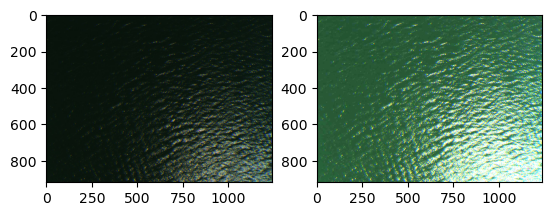

In [39]:
def normalise_image():
    im = np.asarray(Image.open(r"D:\EPMC_flight\8thSur11Aug\F3\thumbnails\IMG_0163_1.jpg"))
    # get normalised rgb image
    im_min = np.percentile(im.flatten(),  0.1)  # modify with these percentilse to adjust contrast
    im_max = np.percentile(im.flatten(), 90)  # for many images, 0.5 and 99.5 are good values
    print(f'dtype: {im.dtype}, max: {im.max()}')
    im_display = np.zeros(im.shape)
    for i in range(im.shape[2]):
        im_display[:,:,i] = imageutils.normalize(im[:,:,i], im_min, im_max)
    
    print(f'dtype: {im_display.dtype}, max: {im_display.max()}')
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(im)
    axes[1].imshow(im_display)
    plt.show()

normalise_image()


shape of canvas(4229, 1339, 3)


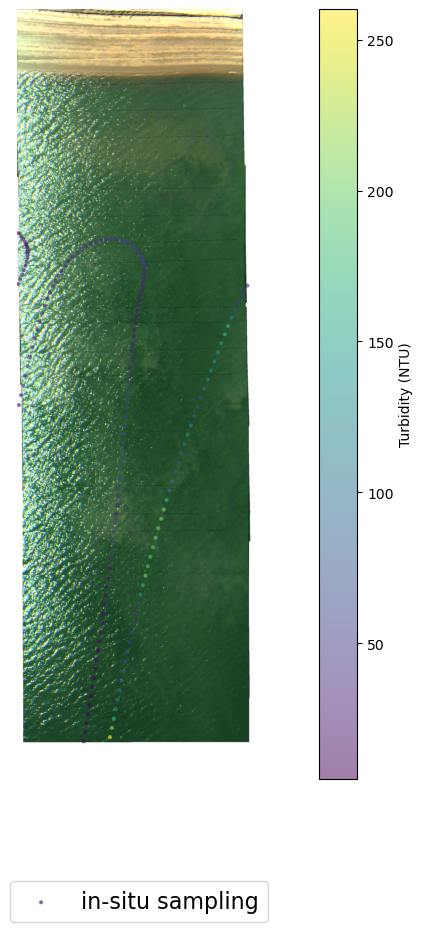

In [42]:
PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,wql_dict,
                                       DEM_offset_height=flight_attributes_df['altitude'].min())
_ = PG.plot_georeference(reduction_factor = 5, plot = True, add_wql=True,
                         normalise=True,p_max=85,
                         s=4)

[1.2366388, 103.6428171, 54.763999999999996, 3.0242828424230046]
Flight angle from coords: 89.430
Flight direction: (-9.040000000015702e-05, 9.000000034120603e-07)


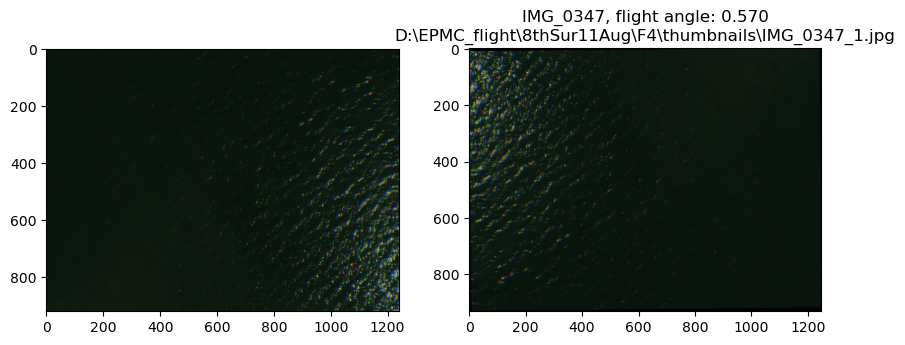

In [41]:
# import image and flight attributes
test_idx = 347
image_name = 'IMG_{}'.format(str(test_idx).zfill(4))
DEM_offset_height = flight_attributes_df['altitude'].min()
column_idx = [i for i,c in enumerate(flight_attributes_df.columns.to_list()) if c in ['latitude','longitude','altitude','dls-yaw']]
flight_att = flight_attributes_df.iloc[test_idx,column_idx].tolist()
flight_att[-2] = flight_att[-2] - DEM_offset_height
im = np.asarray(Image.open(fp_list[test_idx])) if image_name in fp_list[test_idx] else None
print(flight_att)

# estimate flight angle from coordinates
flight_att_diff = flight_attributes_df.iloc[[test_idx-1,test_idx+1],column_idx]
flight_att_diff = flight_att_diff.iloc[:,:2].values
flight_angle_coord = FlightAttributes.get_flight_angle(flight_att_diff)
flight_dir = FlightAttributes.get_flight_direction(flight_att_diff)
print(f'Flight angle from coords: {flight_angle_coord[0]:.3f}')
print(f'Flight direction: {flight_dir}')
flight_angle_coord = flight_angle_coord[0] + 90 if flight_angle_coord[0] > 90 else 90 - flight_angle_coord[0]
if (flight_dir[0] > 0 and flight_dir[1] > 0) or (flight_dir[0] < 0 and flight_dir[1] < 0):
    flight_angle_coord = (flight_angle_coord + 180)%360
# estimation of flight angle from coordinates is better
# geotransform image
GI = FlightAttributes.GeotransformImage(im,*flight_att,angle=flight_angle_coord)
rot_im = GI.georegister()
# _ = GI.affine_transformation(plot=True)
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(im)
axes[1].imshow(np.fliplr(rot_im)) #need to fliplr cus QGIS
axes[1].set_title(f'{image_name}, flight angle: {flight_angle_coord:.3f}\n{fp_list[test_idx]}')
plt.show()

# Sun glint corrections

In [40]:
import algorithms.Hedley as Hedley
import algorithms.SUGAR as sugar
import algorithms.Goodman as Goodman

obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley...
correcting with Goodman...
obtaining reflectance...
correcting with sugar...
correcting with Hedley.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


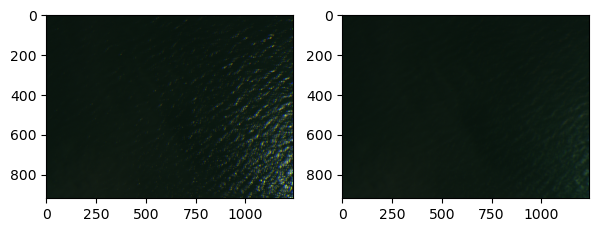

In [42]:
bbox = [(1000,800),(1200,900)]
selected_idxes = selected_imges_dict[6]

parent_dir = os.path.join(os.path.dirname(imagePath),'reflectance_images')
if not os.path.exists(parent_dir):
    reflectance_directory = os.path.join(os.path.dirname(imagePath),'reflectance_images')
    os.mkdir(reflectance_directory)

parent_dir = os.path.join(os.path.dirname(imagePath),'sugar_corrected_images')
if not os.path.exists(parent_dir):
    sugar_corrected_directory = os.path.join(os.path.dirname(imagePath),'sugar_corrected_images')
    os.mkdir(sugar_corrected_directory)

parent_dir = os.path.join(os.path.dirname(imagePath),'hedley_corrected_images')
if not os.path.exists(parent_dir):
    hedley_corrected_directory = os.path.join(os.path.dirname(imagePath),'hedley_corrected_images')
    os.mkdir(hedley_corrected_directory)

parent_dir = os.path.join(os.path.dirname(imagePath),'goodman_corrected_images')
if not os.path.exists(parent_dir):
    goodman_corrected_directory = os.path.join(os.path.dirname(imagePath),'goodman_corrected_images')
    os.mkdir(goodman_corrected_directory)

img_list = [os.path.join(imagePath,f'IMG_{str(i).zfill(4)}_1.tif') for i in selected_idxes]

for i, fp in enumerate(img_list):
    fn = os.path.splitext(os.path.basename(fp))[0]
    reflectance_fn = os.path.join(reflectance_directory,f'{fn}.ob')
    sugar_fn = os.path.join(sugar_corrected_directory,f'{fn}.ob')
    hedley_fn = os.path.join(hedley_corrected_directory,f'{fn}.ob')
    goodman_fn = os.path.join(goodman_corrected_directory,f'{fn}.ob')

    cap = mutils.import_captures(fp)
    RI = espect.ReflectanceImage(cap,warp_matrices,cropped_dimensions)
    print('obtaining reflectance...')
    im_aligned = RI.get_aligned_reflectance()
    print('correcting with sugar...')
    corrected_bands = sugar.correction_iterative(im_aligned,iter=3,plot=False)
    print('correcting with Hedley...')
    HH = Hedley.Hedley(im_aligned,bbox,smoothing=False,glint_mask=False)
    corrected_Hedley = HH.get_corrected_bands(plot=False)
    corrected_Hedley = np.stack(corrected_Hedley,axis=2)
    print('correcting with Goodman...')
    GM = Goodman.Goodman(im_aligned)
    corrected_Goodman = GM.get_corrected_bands()
    corrected_Goodman = np.stack(corrected_Goodman,axis=2)
    
    with open(reflectance_fn,'wb') as f:
        pickle.dump(im_aligned,f)
    with open(sugar_fn,'wb') as f:
        pickle.dump(corrected_bands[-1],f)
    with open(hedley_fn,'wb') as f:
        pickle.dump(corrected_Hedley,f)
    with open(goodman_fn,'wb') as f:
        pickle.dump(corrected_Goodman,f)

fig, axes = plt.subplots(1,2,figsize=(7,3))
axes[0].imshow(np.take(im_aligned,[2,1,0],axis=2))
axes[1].imshow(np.take(corrected_bands[-1],[2,1,0],axis=2))
plt.show()

# Extract spectral information

In [63]:
selected_idxes = selected_imges_dict[6]
reflectance_dirs = [reflectance_directory, hedley_corrected_directory, goodman_corrected_directory, sugar_corrected_directory]
titles = ['R_T','Hedley','Goodman','SUGAR']
td = -1.5
DEM_offset_height = flight_attributes_df['altitude'].min()

CIS = FlightAttributes.CompareInsituSpectral(selected_idxes,reflectance_dirs,df_interpolated,wql_dict,
                                             titles,timedelta=td,DEM_offset_height=DEM_offset_height)
CIS.extract_spectral(save_dir = os.path.split(imagePath)[0])


rows shifted: -15


c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in

extracted spectral data saved in D:\EPMC_flight\8thSur11Aug\F4\Extracted_Spectral_Information


shape of canvas(4229, 1339, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of canvas(4229, 1339, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of canvas(4229, 1339, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of canvas(4229, 1339, 3)


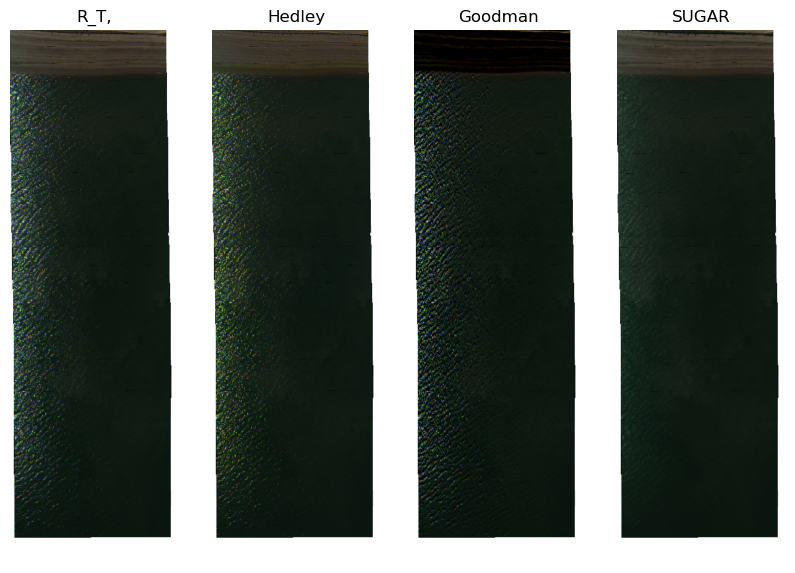

In [64]:
CIS.compare_rgb()

# Analyse extracted spectral

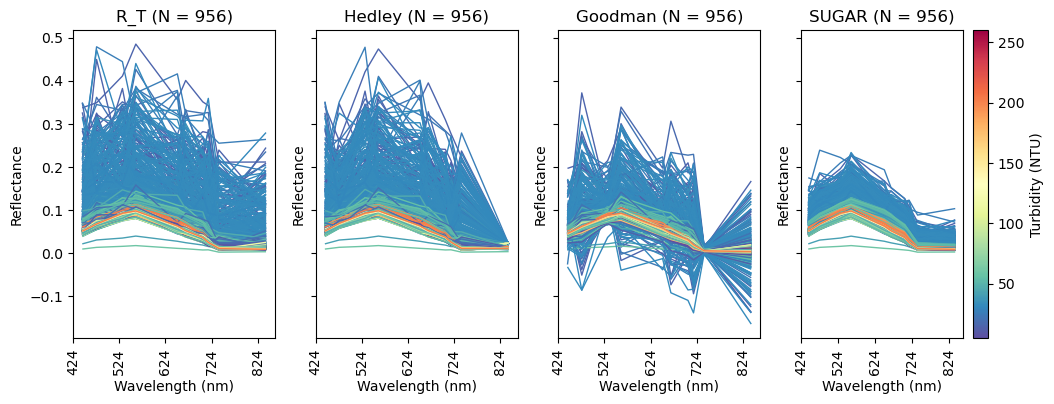

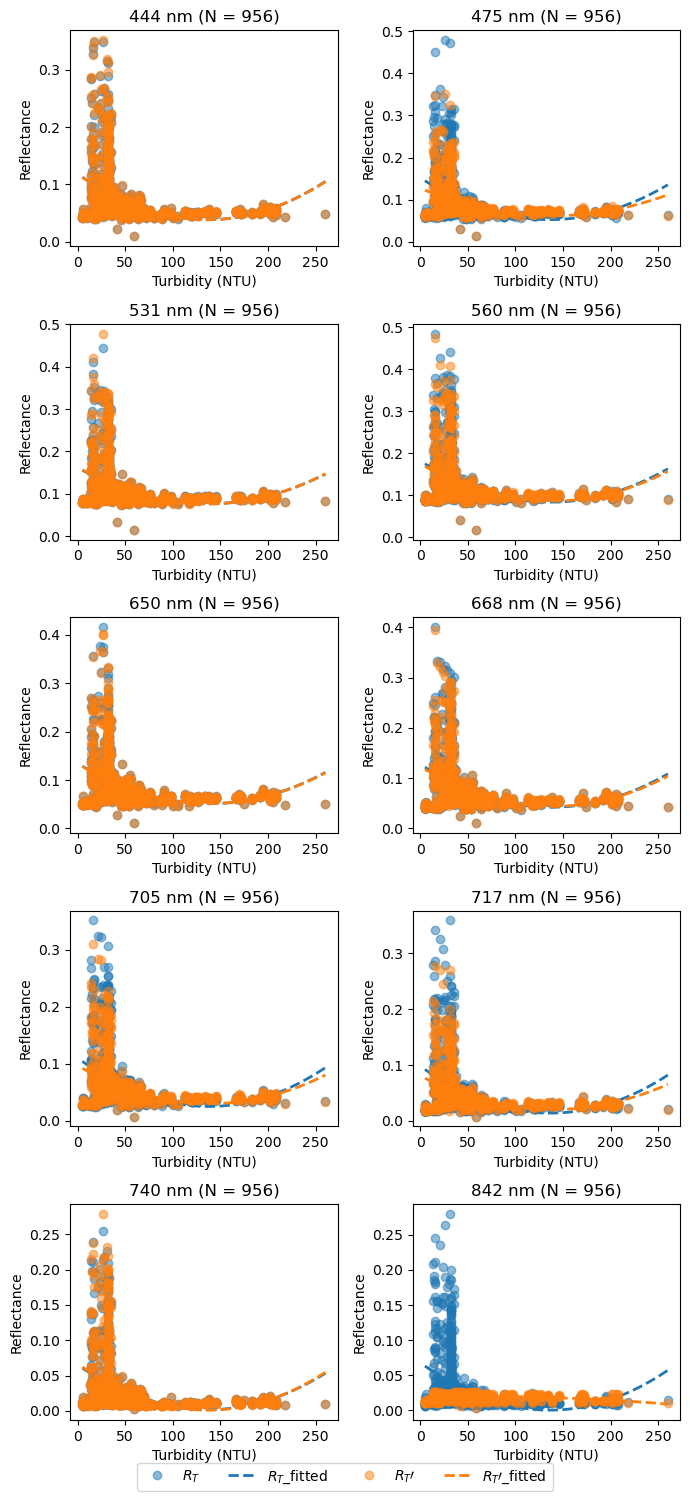

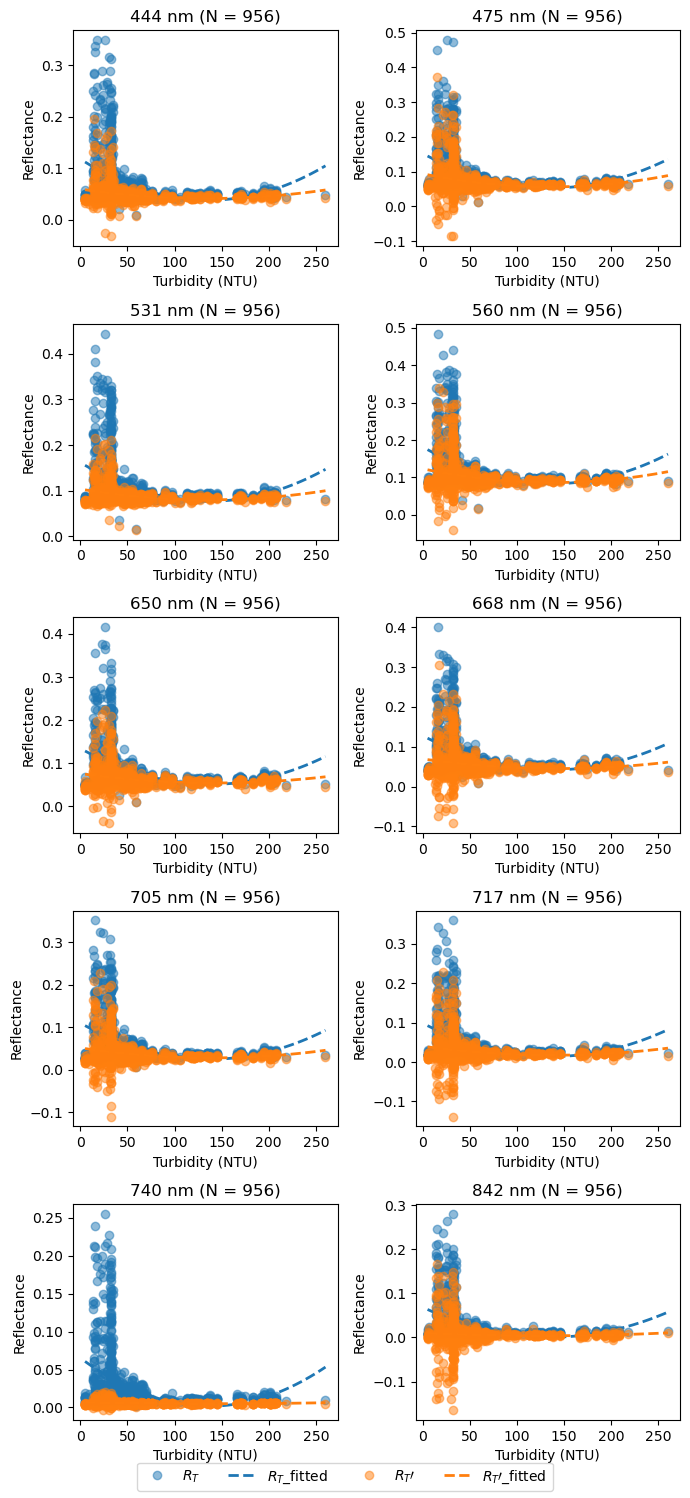

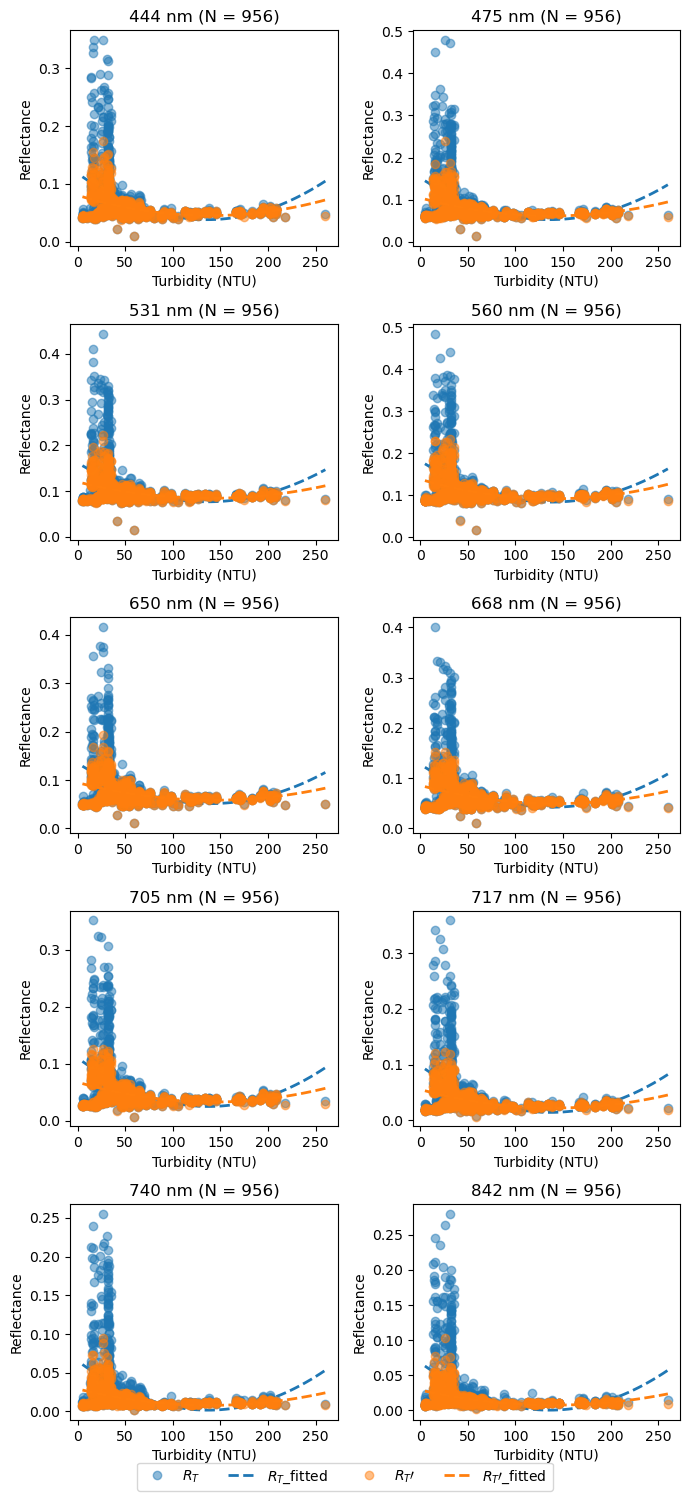

original    Hedley   Goodman     SUGAR
Wavelength                                        
444         0.044499  0.044581  0.017207  0.018498
475         0.053387  0.036161  0.037400  0.021795
531         0.049327  0.050320  0.017861  0.020332
560         0.055045  0.050509  0.037248  0.025092
650         0.048090  0.048049  0.024399  0.020991
668         0.048689  0.045724  0.033135  0.020177
705         0.046042  0.037117  0.027655  0.018309
717         0.045724  0.033290  0.031695  0.016821
740         0.036554  0.037815  0.002218  0.010695
842         0.036371  0.003939  0.027448  0.010477

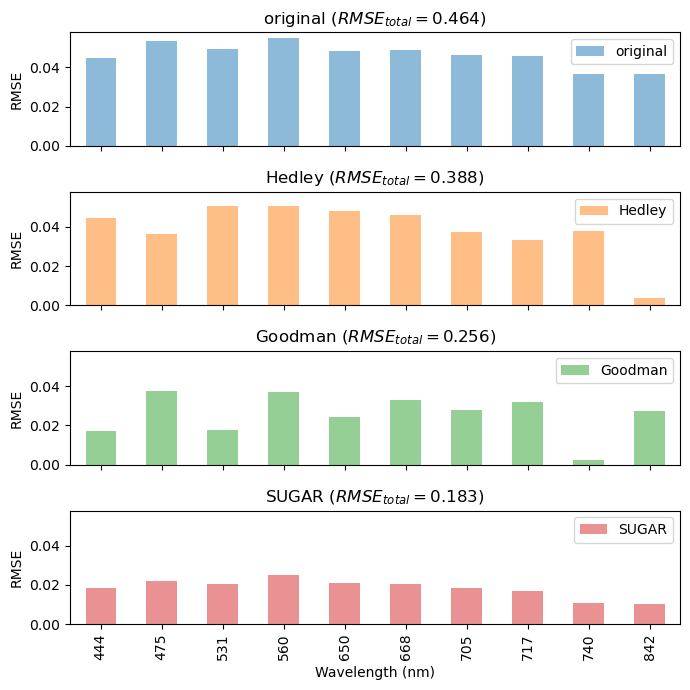

In [43]:
extracted_spectral_dir = r"D:\EPMC_flight\8thSur11Aug\F4\Extracted_Spectral_Information"
extracted_spectral_fp_list = [os.path.join(extracted_spectral_dir,fp) for fp in os.listdir(extracted_spectral_dir)]
titles = ['R_T','Hedley','Goodman','SUGAR']
VI = ValidateAlgo.ValidateInsitu(extracted_spectral_fp_list,titles,conc_index=2,
                    save_dir=r"D:\EPMC_flight\8thSur11Aug\F4")
VI.plot_conc_spectral()
VI.get_metrics(nrows=5,ncols=2,figsize=(7,15))
VI.compare_rmse(figsize=(7,7))

# Plot spectral and georeference and wql

shape of canvas(4229, 1339, 3)


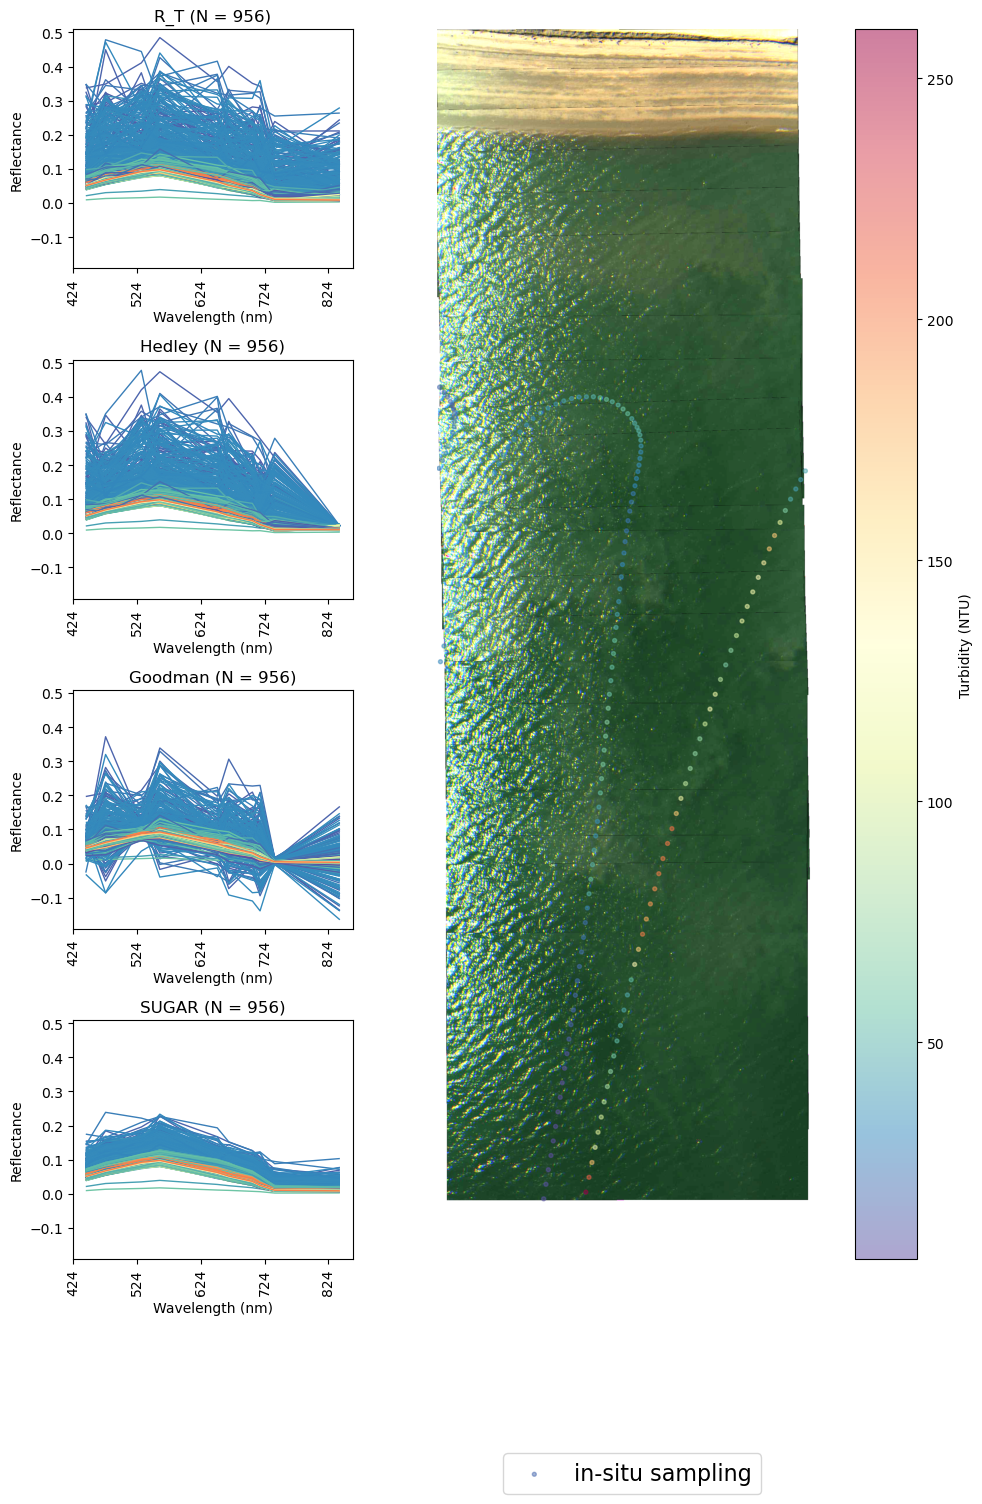

In [54]:
ValidateAlgo.plot_insitu_spectral(PG,VI,
                                  normalise=True,p_max=85,
                                  s=8,figsize=(10,15))

to-do: normalise image to show plume better